In [22]:
import os
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
from pathlib import Path
import shutil
# Import YOLO and Roboflow
from ultralytics import YOLO
from roboflow import Roboflow

#### ====================================
#### 1. DATASET DOWNLOAD FROM ROBOFLOW
#### ====================================

In [ ]:
rf = Roboflow(api_key="XXXXXXXXXXXXXXXXXX")
project = rf.workspace("najm-xl558").project("car-crash-detection-db4vm-utvd2")
version = project.version(3)
dataset = version.download("yolov8")      

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to car-crash-detection-3 in yolov8:: 100%|██████████| 12600/12600 [00:02<00:00, 5419.32it/s]


In [24]:
# Get dataset path
dataset_path = dataset.location
print(f"Dataset downloaded to: {dataset_path}")

Dataset downloaded to: /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3


#### ====================================
#### 2. EXPLORATORY DATA ANALYSIS (EDA)
#### ====================================

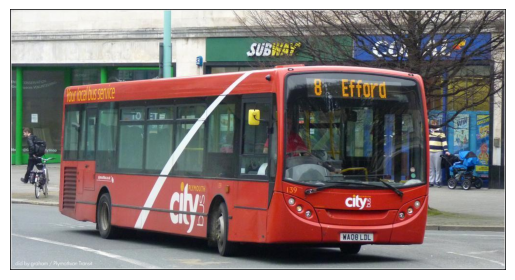

In [ ]:
image_file = os.path.join('Drones_Bootcamp/car-crash-detection-3/train/images/00c96e0e060aeb2f_jpg.rf.6b96dd883bced26f205bfba6e202fedc.jpg')
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

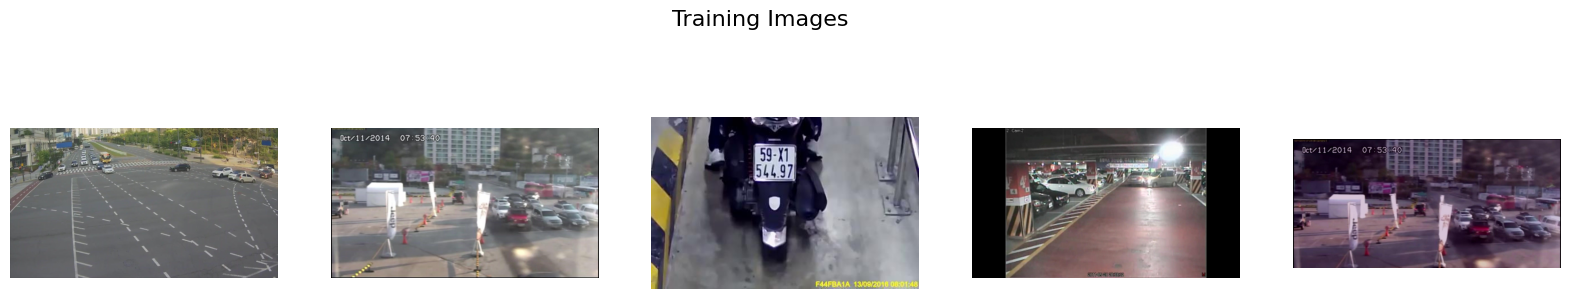

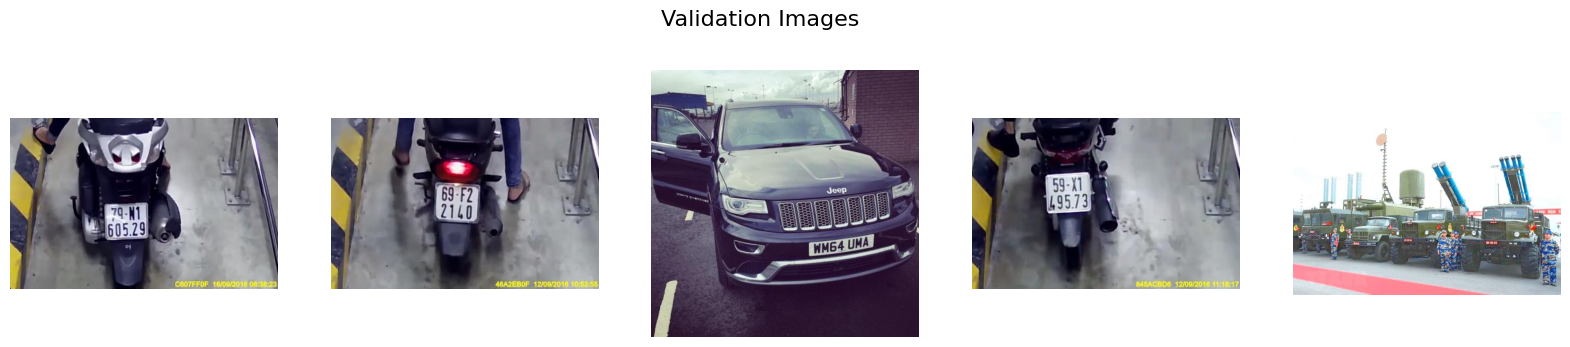

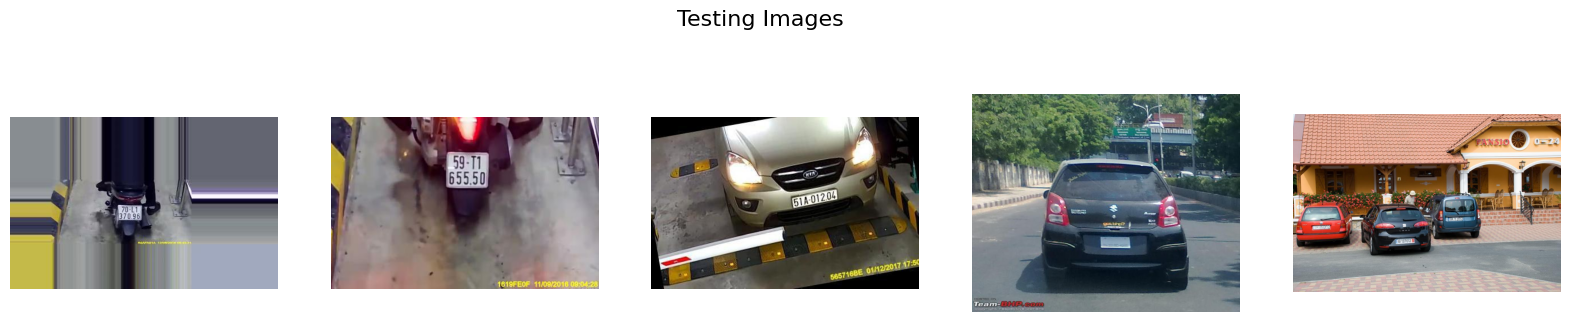

In [ ]:
test_dataset_path= 'Drones_Bootcamp/car-crash-detection-3/test/images'
train_dataset_path='Drones_Bootcamp/car-crash-detection-3/train/images'
valid_dataset_path='Desktop/Drones_Bootcamp/car-crash-detection-3/valid/images'

def display_images(dataset_path, title):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    for i, filename in enumerate(os.listdir(dataset_path)[:5]):
        image_path = os.path.join(dataset_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axs[i].imshow(image)
        axs[i].axis('off')

    plt.show()

display_images(train_dataset_path, "Training Images")
display_images(valid_dataset_path, "Validation Images")
display_images(test_dataset_path, "Testing Images")

In [31]:
def load_dataset_info(dataset_path):
    data_yaml_path = os.path.join(dataset_path, 'data.yaml')
    
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    
    print("Dataset Configuration:")
    print(f"Classes: {data_config['names']}")
    print(f"Number of classes: {data_config['nc']}")
    print(f"Train path: {data_config.get('train', 'Not specified')}")
    print(f"Val path: {data_config.get('val', 'Not specified')}")
    print(f"Test path: {data_config.get('test', 'Not specified')}")
    
    return data_config

print("=== DATASET ANALYSIS ===")
data_config = load_dataset_info(dataset_path)

=== DATASET ANALYSIS ===
Dataset Configuration:
Classes: ['Car-to-Bicycle-Crash', 'Car-to-Car-Crash', 'Car-to-Motorcycle-Crash', 'Car-to-Pedestrian-Crash', 'License_Plate']
Number of classes: 5
Train path: ../train/images
Val path: ../valid/images
Test path: ../test/images


In [32]:
def count_images_and_labels(dataset_path):
    splits = ['train', 'valid', 'test']
    counts = {}
    
    for split in splits:
        images_path = os.path.join(dataset_path, split, 'images')
        labels_path = os.path.join(dataset_path, split, 'labels')
        
        if os.path.exists(images_path):
            image_count = len([f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            label_count = len([f for f in os.listdir(labels_path) if f.endswith('.txt')]) if os.path.exists(labels_path) else 0
            counts[split] = {'images': image_count, 'labels': label_count}
            print(f"{split.capitalize()}: {image_count} images, {label_count} labels")
        else:
            counts[split] = {'images': 0, 'labels': 0}
            print(f"{split.capitalize()}: Directory not found")
    
    return counts

print("=== IMAGE AND LABEL COUNTS ===")
counts = count_images_and_labels(dataset_path)

=== IMAGE AND LABEL COUNTS ===
Train: 4997 images, 4997 labels
Valid: 648 images, 648 labels
Test: 649 images, 649 labels


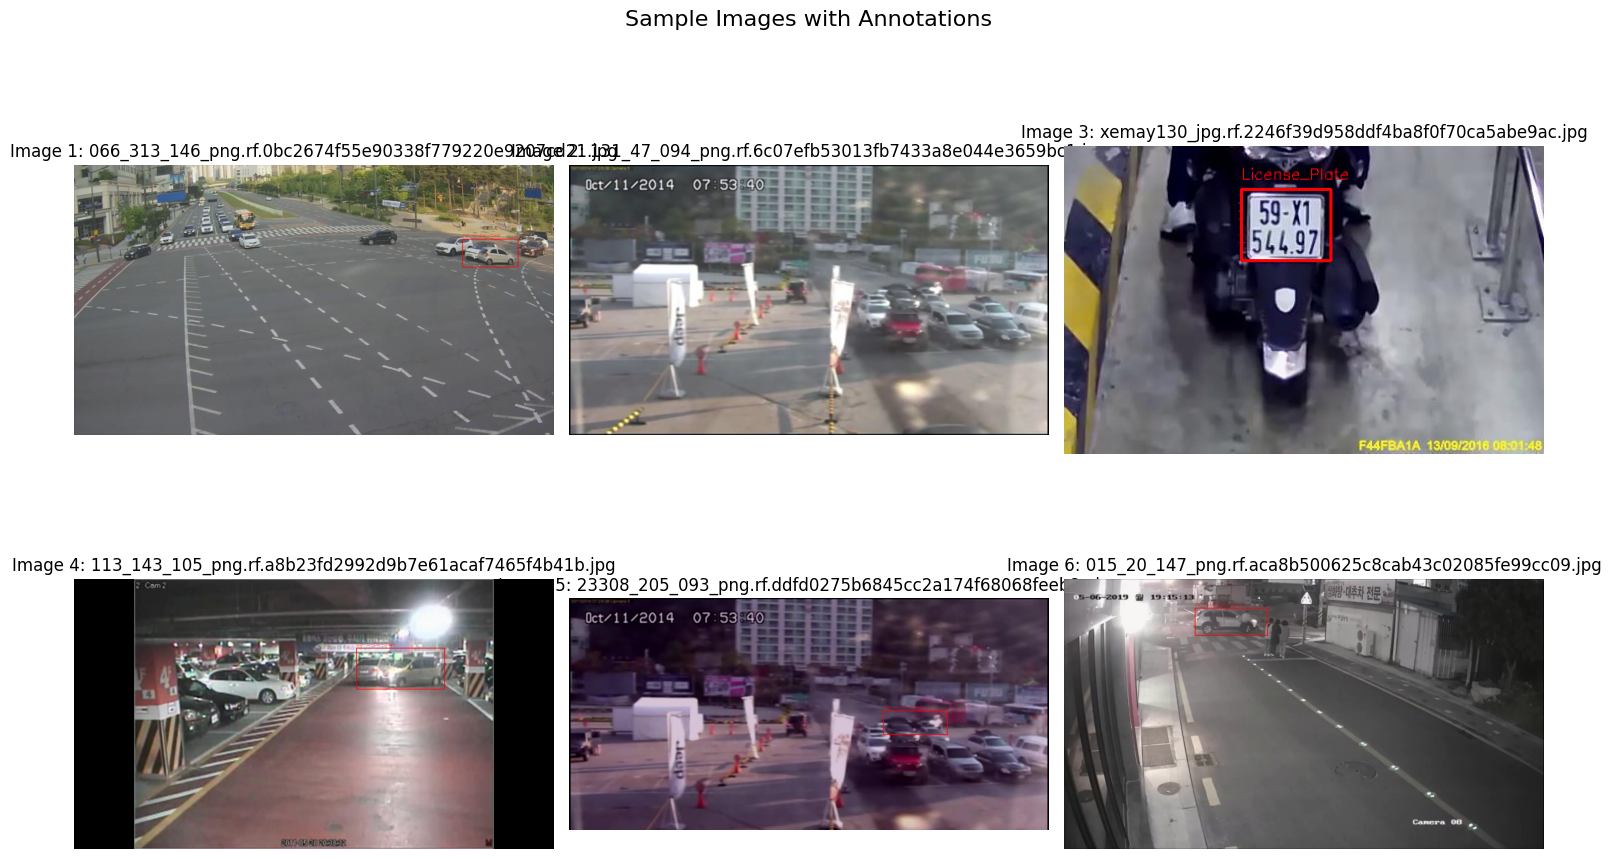

In [ ]:
def visualize_sample_images(dataset_path, class_names, num_samples=6):
    train_images_path = os.path.join(dataset_path, 'train', 'images')
    train_labels_path = os.path.join(dataset_path, 'train', 'labels')
    
    if not os.path.exists(train_images_path):
        print("Training images not found")
        return
    
    image_files = [f for f in os.listdir(train_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Sample Images with Annotations', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i >= len(image_files) or i >= num_samples:
            ax.axis('off')
            continue
            
        # Load image
        img_path = os.path.join(train_images_path, image_files[i])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # Load corresponding label
        label_file = os.path.splitext(image_files[i])[0] + '.txt'
        label_path = os.path.join(train_labels_path, label_file)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # Draw bounding boxes
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])
                    
                    # Convert normalized coordinates to pixel coordinates
                    x1 = int((x_center - width/2) * w)
                    y1 = int((y_center - height/2) * h)
                    x2 = int((x_center + width/2) * w)
                    y2 = int((y_center + height/2) * h)
                    
                    # Draw rectangle
                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    
                    # Add class label
                    class_name = class_names[class_id] if class_id < len(class_names) else 'unknown'
                    cv2.putText(image, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        ax.imshow(image)
        ax.set_title(f'Image {i+1}: {image_files[i]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


visualize_sample_images(dataset_path, data_config['names'])

#### ====================================
#### 4. MODEL TRAINING
#### ====================================

In [34]:
print("=== TRAINING YOLOV8 MODEL ===")
model = YOLO('yolov8n.pt')  # {yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt}
training_args = {
    'data': os.path.join(dataset_path, 'data.yaml'),
    'epochs': 10,          
    'imgsz': 640,           # Image size
    'batch': 16            # Batch size 
}
results = model.train(**training_args)
print("Training completed!")
print(f"Best model saved at: {model.trainer.best}")

=== TRAINING YOLOV8 MODEL ===
WARNING ⚠️ Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8n.pt...


Python(9353) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
######################################################################## 100.0%


New https://pypi.org/project/ultralytics/8.3.185 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.183 🚀 Python-3.12.4 torch-2.8.0 CPU (Apple M2)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, ops

train: Scanning /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/train/labels... 4997 images, 171 backgrounds, 0 corrupt: 100%|██████████| 4997/4997 [00:01<00:00, 4047.03it/s]

train: New cache created: /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 143.4±47.6 MB/s, size: 22.9 KB)


val: Scanning /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/valid/labels... 648 images, 8 backgrounds, 0 corrupt: 100%|██████████| 648/648 [00:00<00:00, 3940.02it/s]

val: New cache created: /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/valid/labels.cache
Plotting labels to /Users/macbook/runs/detect/train3/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/macbook/runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.481      3.336      1.355          4        640: 100%|██████████| 313/313 [27:46<00:00,  5.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:58<00:00,  2.79s/it]

                   all        648        666      0.663      0.726      0.817      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.401       1.86      1.259          5        640: 100%|██████████| 313/313 [28:26<00:00,  5.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:57<00:00,  2.75s/it]

                   all        648        666       0.78      0.818      0.858      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/10         0G      1.379      1.319      1.257          7        640: 100%|██████████| 313/313 [35:57<00:00,  6.89s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:57<00:00,  2.74s/it]

                   all        648        666      0.839      0.827      0.891      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/10         0G      1.321      1.051      1.207          5        640: 100%|██████████| 313/313 [1:29:00<00:00, 17.06s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [03:45<00:00, 10.75s/it]

                   all        648        666      0.943      0.864       0.96      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/10         0G      1.272     0.8827      1.177          5        640: 100%|██████████| 313/313 [27:59<00:00,  5.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:58<00:00,  2.77s/it]

                   all        648        666       0.89      0.943      0.957      0.675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/10         0G      1.211     0.7735      1.148          6        640: 100%|██████████| 313/313 [28:06<00:00,  5.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:58<00:00,  2.78s/it]

                   all        648        666      0.932      0.964       0.98      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/10         0G      1.173      0.694      1.125          7        640: 100%|██████████| 313/313 [28:18<00:00,  5.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:57<00:00,  2.74s/it]

                   all        648        666      0.939      0.977      0.985      0.695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/10         0G      1.136     0.6375        1.1          5        640: 100%|██████████| 313/313 [59:33<00:00, 11.42s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [01:00<00:00,  2.89s/it]

                   all        648        666      0.935      0.963      0.983      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/10         0G      1.092     0.5842      1.074          5        640: 100%|██████████| 313/313 [28:25<00:00,  5.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:58<00:00,  2.78s/it]

                   all        648        666      0.961      0.982      0.991      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/10         0G      1.059     0.5454      1.054          6        640: 100%|██████████| 313/313 [27:50<00:00,  5.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:58<00:00,  2.77s/it]

                   all        648        666      0.967      0.982      0.992      0.758

10 epochs completed in 6.566 hours.


Optimizer stripped from /Users/macbook/runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from /Users/macbook/runs/detect/train3/weights/best.pt, 6.2MB

Validating /Users/macbook/runs/detect/train3/weights/best.pt...
Ultralytics 8.3.183 🚀 Python-3.12.4 torch-2.8.0 CPU (Apple M2)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:55<00:00,  2.64s/it]


                   all        648        666      0.967      0.983      0.992      0.758
  Car-to-Bicycle-Crash         22         22      0.924          1      0.995      0.748
      Car-to-Car-Crash         77         77          1      0.991      0.995       0.76
Car-to-Motorcycle-Crash         20         20      0.972          1      0.995       0.81
Car-to-Pedestrian-Crash         44         44      0.956      0.989      0.988       0.76
         License_Plate        477        503      0.983      0.933      0.984      0.711
Speed: 0.6ms preprocess, 81.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /Users/macbook/runs/detect/train3
Training completed!
Best model saved at: /Users/macbook/runs/detect/train3/weights/best.pt


#### ====================================
#### 5. MODEL EVALUATION
#### ====================================

In [35]:
print("\n=== MODEL EVALUATION ===")

best_model = YOLO(model.trainer.best) # Load the best trained model
val_results = best_model.val() # Evaluate on validation set
print(f"Validation mAP50: {val_results.box.map50:.4f}") # Print validation metrics
print(f"Validation mAP50-95: {val_results.box.map:.4f}")


=== MODEL EVALUATION ===
Ultralytics 8.3.183 🚀 Python-3.12.4 torch-2.8.0 CPU (Apple M2)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 202.8±136.8 MB/s, size: 136.4 KB)


val: Scanning /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/valid/labels.cache... 648 images, 8 backgrounds, 0 corrupt: 100%|██████████| 648/648 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [01:05<00:00,  1.59s/it]


                   all        648        666      0.965      0.984      0.991      0.758
  Car-to-Bicycle-Crash         22         22      0.918          1      0.993      0.747
      Car-to-Car-Crash         77         77          1       0.99      0.995      0.763
Car-to-Motorcycle-Crash         20         20       0.97          1      0.995      0.809
Car-to-Pedestrian-Crash         44         44      0.956      0.994      0.988       0.76
         License_Plate        477        503      0.981      0.935      0.984      0.711
Speed: 0.4ms preprocess, 96.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /Users/macbook/runs/detect/val3
Validation mAP50: 0.9912
Validation mAP50-95: 0.7581


In [36]:
test_path = os.path.join(dataset_path, 'test') # Evaluate on test set (if available)
if os.path.exists(test_path):
    test_results = best_model.val(data=os.path.join(dataset_path, 'data.yaml'), split='test')
    print(f"Test mAP50: {test_results.box.map50:.4f}")
    print(f"Test mAP50-95: {test_results.box.map:.4f}")

Ultralytics 8.3.183 🚀 Python-3.12.4 torch-2.8.0 CPU (Apple M2)
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 127.2±123.3 MB/s, size: 33.1 KB)


val: Scanning /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/test/labels... 649 images, 34 backgrounds, 0 corrupt: 100%|██████████| 649/649 [00:00<00:00, 4607.93it/s]

val: New cache created: /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 41/41 [01:06<00:00,  1.62s/it]


                   all        649        622      0.927      0.984      0.951      0.665
         License_Plate        615        622      0.927      0.984      0.951      0.665
Speed: 0.4ms preprocess, 99.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /Users/macbook/runs/detect/val4
Test mAP50: 0.9513
Test mAP50-95: 0.6647


In [37]:
# Save the model
def save_final_model():
    best_model_path = model.trainer.best
    print(f"Best model location: {best_model_path}")
    import shutil
    simple_name = "car_crash_detector_model.pt"
    shutil.copy2(best_model_path, simple_name)
    print(f"Model copied to: {simple_name}")

In [38]:
final_model = save_final_model()

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print(f"Your model is saved as: {final_model}")
print("="*50)

Best model location: /Users/macbook/runs/detect/train3/weights/best.pt
Model copied to: car_crash_detector_model.pt

TRAINING COMPLETE!
Your model is saved as: None


Testing on some images...



image 1/1 /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/test/images/xemay2113_jpg.rf.a499511ff25bc90cfd415e68d0ba39a6.jpg: 416x640 1 License_Plate, 79.5ms
Speed: 1.6ms preprocess, 79.5ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/test/images/xemay602_jpg.rf.ed23c28707e4663b6e6e1395e1829327.jpg: 416x640 1 License_Plate, 33.3ms
Speed: 0.9ms preprocess, 33.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/test/images/CarLongPlateGen3468_jpg.rf.2dfed7adcbcf909fe87a79273a6681ed.jpg: 416x640 1 License_Plate, 33.6ms
Speed: 0.8ms preprocess, 33.6ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /Users/macbook/Desktop/Drones_Bootcamp/car-crash-detection-3/test/images/pic_511_jpg.rf.1b3bd95053b2d94a5e7be4f21ec7e199.jpg: 544x640 1 License_Plate, 50.0ms
Speed: 1.3ms prepro

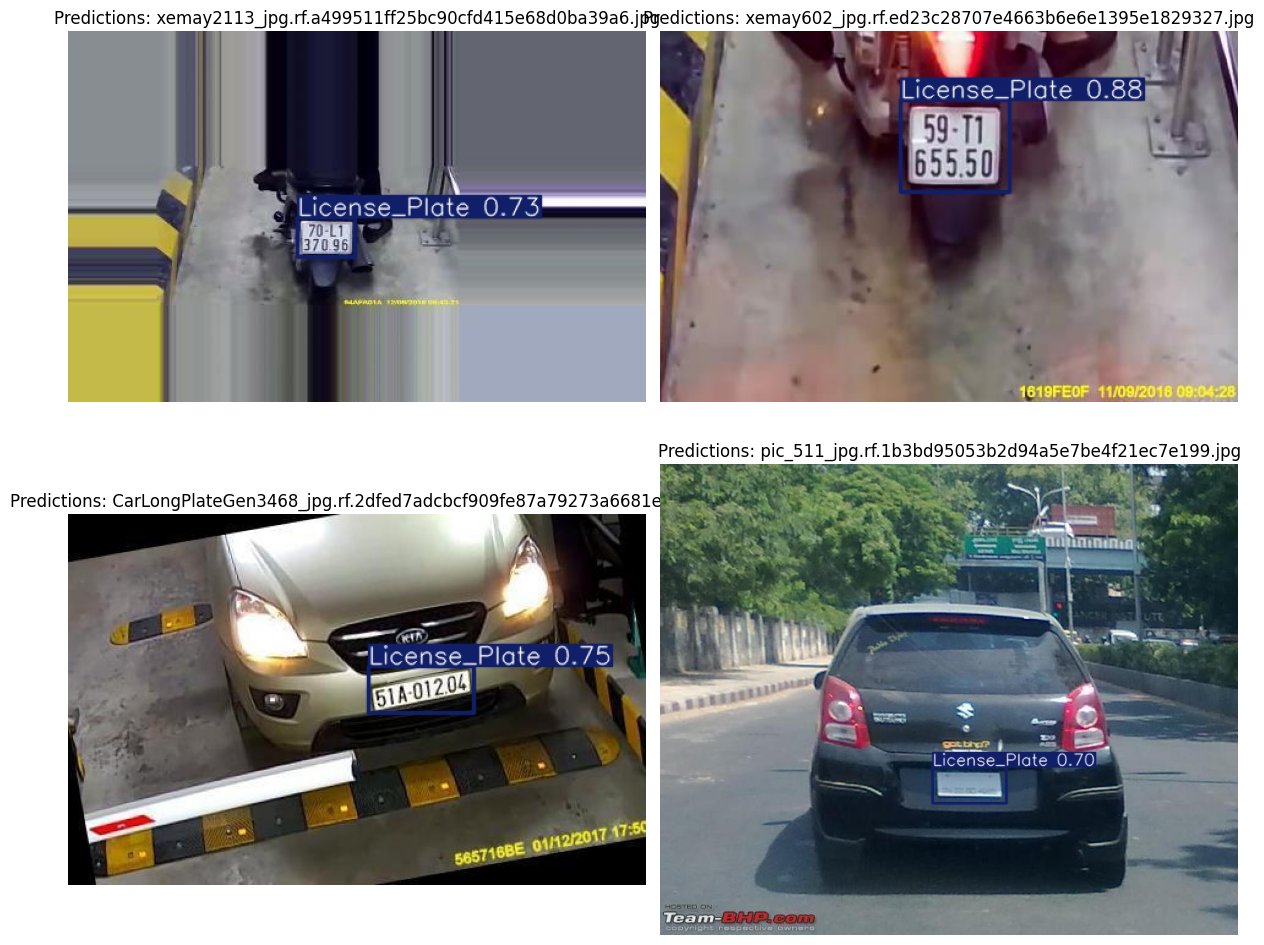

In [40]:
# See some predictions
def show_predictions():
    print("Testing on some images...")
    test_folder = f"{dataset.location}/test/images"
    test_images = os.listdir(test_folder)[:4]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for i, img_name in enumerate(test_images):
        img_path = f"{test_folder}/{img_name}"
        results = best_model(img_path)
        
        # Get the plotted image with predictions
        result_img = results[0].plot()
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        
        axes[i//2, i%2].imshow(result_img)
        axes[i//2, i%2].set_title(f"Predictions: {img_name}")
        axes[i//2, i%2].axis('off')
    
    plt.tight_layout()
    plt.show()

show_predictions()

# infernce 

In [ ]:
def detect_crashes(image_path):
    model = YOLO(best_model)
    results = model(image_path)
    results[0].show()  
    return results

detect_crashes(r'')